In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
%matplotlib inline


# the switching binomial generative model


In [2]:
t_titre = 35
t_label = 25
fig_width= 15
N_scan = 100
N_scan = 10 # DEBUG

In [3]:
observer = 'AM'
mode = 'pari'
from aSPEM import Analysis
e = Analysis(observer=observer, mode=mode)

## evaluating the best hazard rate using a likelihood score

Vérifier tau !

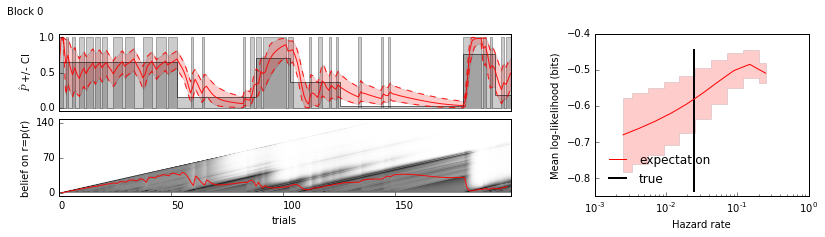

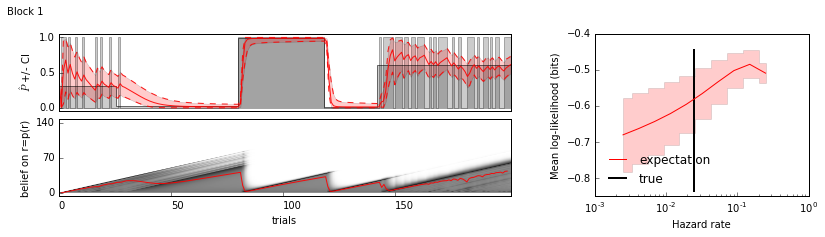

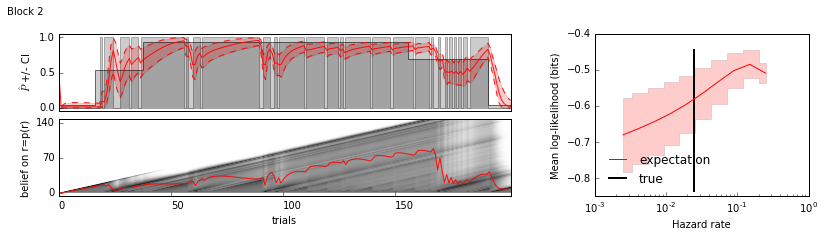

In [4]:
fig, axs = e.plot_bcp(N_scan=N_scan)

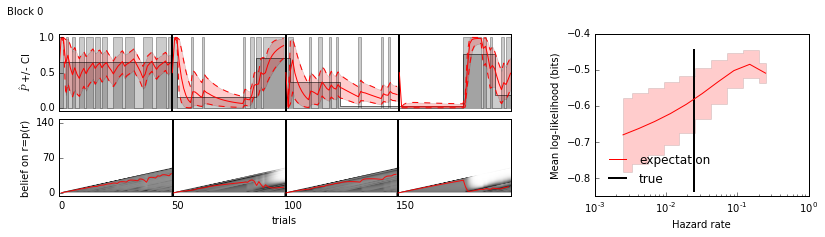

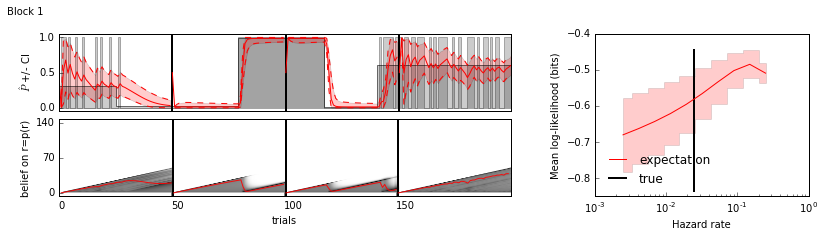

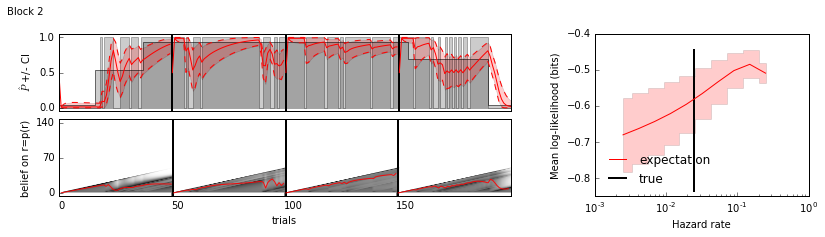

In [5]:
fig, axs = e.plot_bcp(N_scan=N_scan, pause=True)

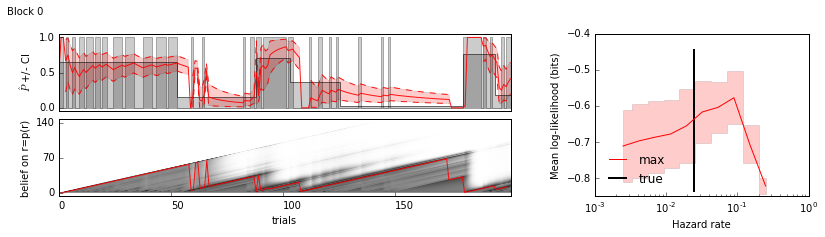

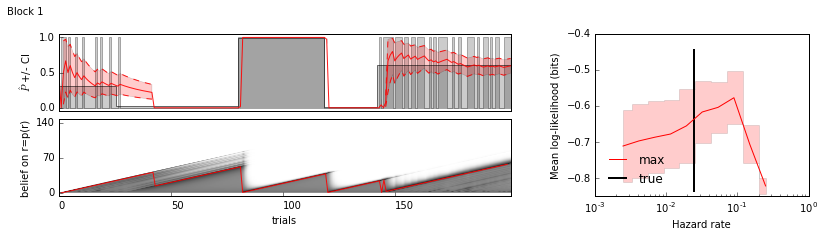

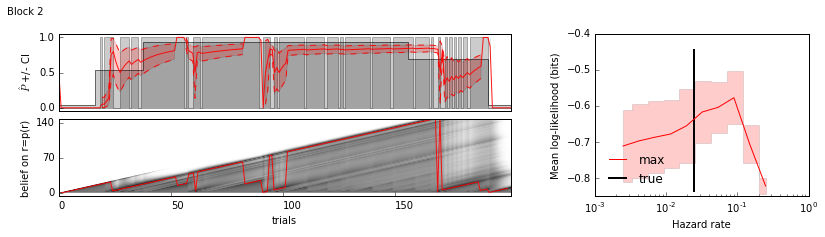

In [6]:
fig, axs = e.plot_bcp(N_scan=N_scan, mode='max')

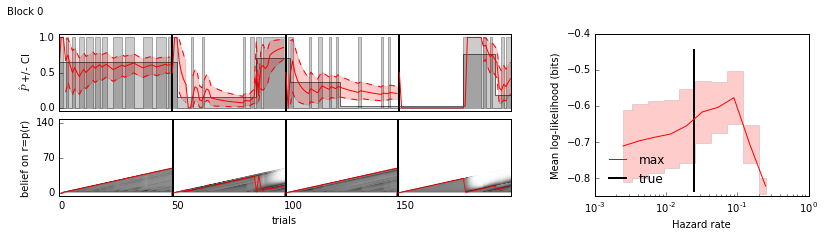

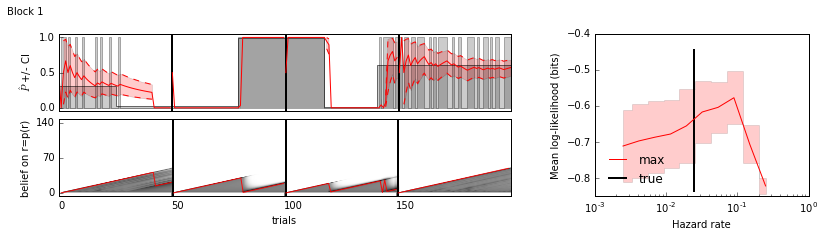

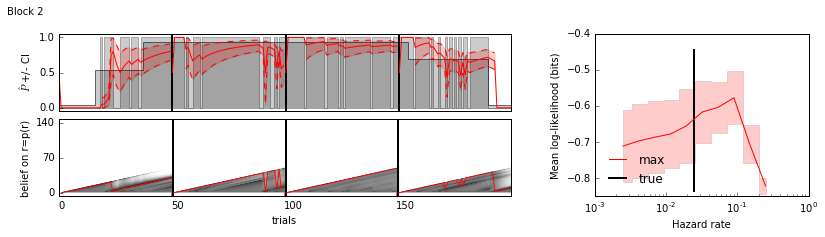

In [7]:
fig, axs = e.plot_bcp(N_scan=N_scan, mode='max', pause=True)

Block 2


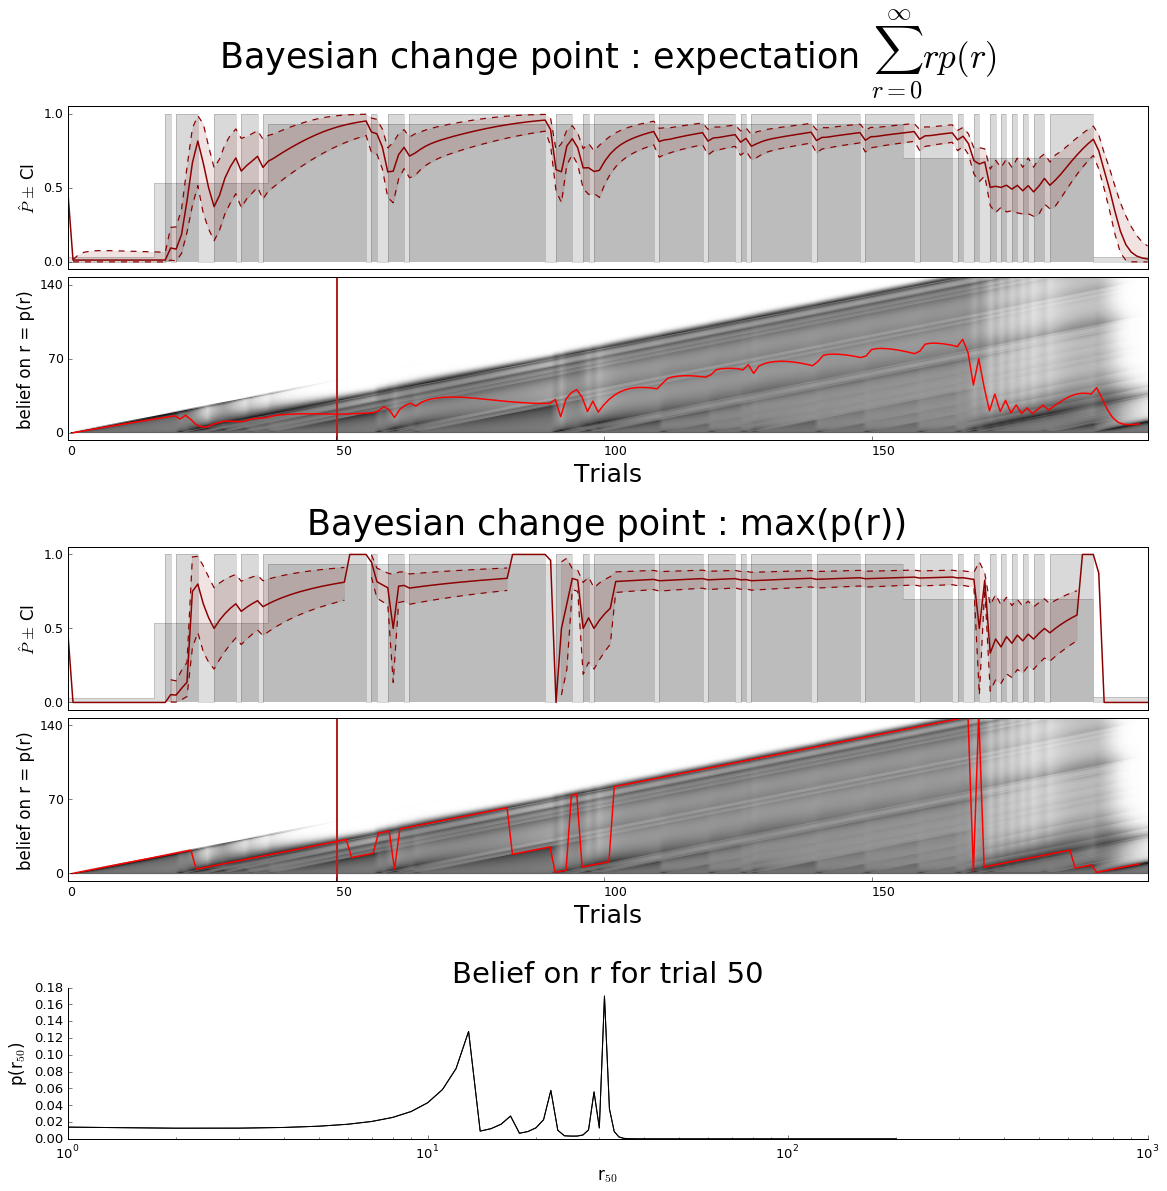

In [8]:
fig, axs = e.plot_bcp_2(block=2, trial=50)